In [3]:
import sys
sys.path.append("..")

import os
import numpy as np
import pandas as pd
from pathlib import Path
import pickle
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

from envs.trading_env import MyTradingEnv


INITIAL_BALANCE = 1000.0
WINDOW_SIZE = 10
COMMISSION = 0.0001
SLIPPAGE = 0.0005
MAX_HOLDING_TIME = 60 * 24
HOLDING_THRESHOLD = 24
MAX_DRAWDOWN_THRESHOLD = 0.05
LAMBDA_DRAWDOWN = 0.1
LAMBDA_HOLD = 0.01
REWARD_SCALING=10.0
MAX_STEPS=None

TRAIN_VERSION = "v1"

df1 = pd.read_csv("../data/data_1h_2021.csv", index_col=0, parse_dates=True)
df2 = pd.read_csv("../data/data_1h_2022.csv", index_col=0, parse_dates=True)
df3 = pd.read_csv("../data/data_1h_2023.csv", index_col=0, parse_dates=True)
df4 = pd.read_csv("../data/data_1h_2024.csv", index_col=0, parse_dates=True)

train_data = pd.concat([df1])

df_full = train_data.copy()


Q-Learning
------------------------------------------------------------

SARSA
------------------------------------------------------------

SARSA-λ
------------------------------------------------------------

Monte Carlo
------------------------------------------------------------


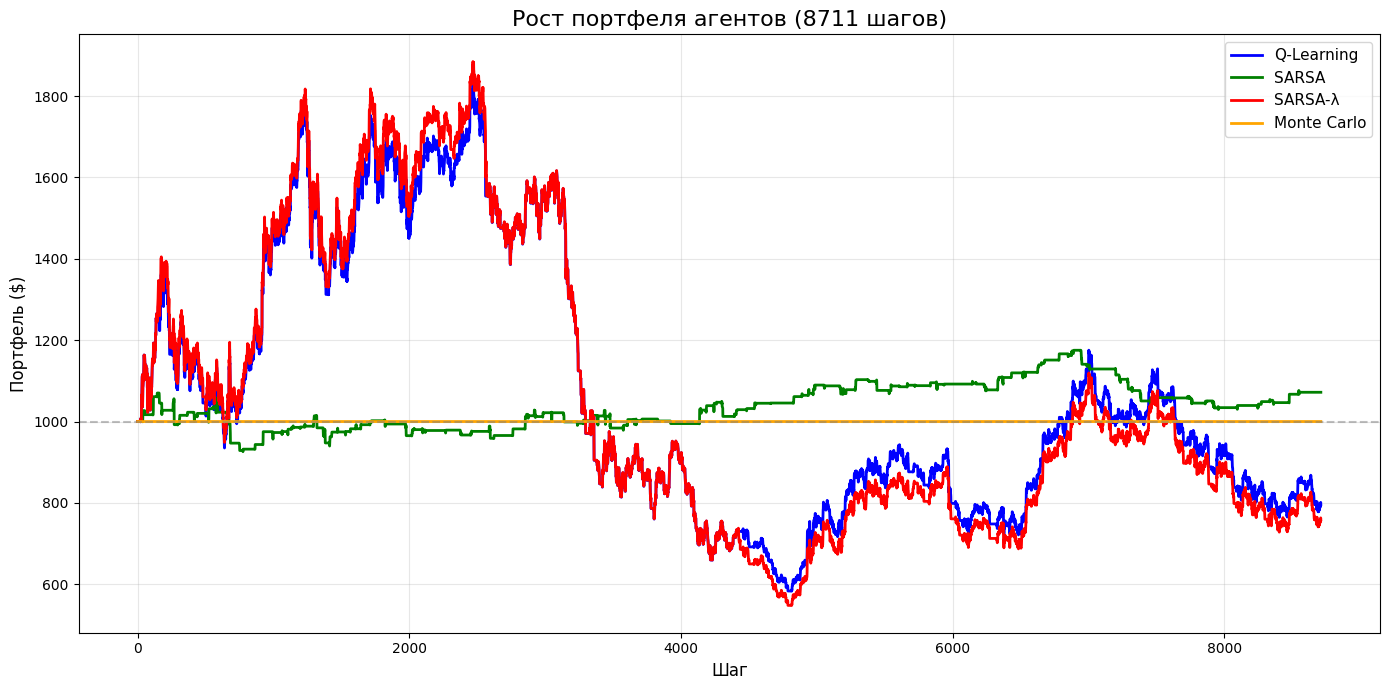


РЕЗУЛЬТАТЫ ТЕСТИРОВАНИЯ
         Агент  Доходность %  Конечный баланс  Сделок  Win Rate %  \
0   Q-Learning        -20.38           796.16      45       22.22   
1        SARSA          7.19         1,071.93     169       61.54   
2      SARSA-λ        -24.17           758.33      45       20.00   
3  Monte Carlo          0.00         1,000.00       0        0.00   

   Средний PnL  Max Drawdown сделок %  Max Drawdown портфеля %  Sharpe Ratio  \
0        -4.40                   8.79                    68.07          0.02   
1         0.53                   5.16                    13.48          0.08   
2        -5.24                   8.79                    70.95          0.01   
3         0.00                   0.00                     0.00          0.00   

   Ср. время удержания  Закрыто по просадке  Закрыто по времени  
0               169.38                   34                   0  
1                 3.62                    0                   0  
2               170.24        

In [4]:
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

class QLearningLoaded:
    def __init__(self, data):
        self.q_table = data["q_table"]
        self.n_actions = data["n_actions"]
        self.epsilon = 0.0

    def select_action(self, state, training=False):
        key = tuple(state)
        q = self.q_table.get(key)
        if q is None:
            return 0
        return int(np.argmax(q))


class SARSALoaded:
    def __init__(self, data):
        self.q_table = data["q_table"]
        self.n_actions = data["n_actions"]
        self.epsilon = 0.0

    def select_action(self, state, training=False):
        key = tuple(state)
        q = self.q_table.get(key)
        if q is None:
            return 0
        return int(np.argmax(q))


class SARSALambdaLoaded:
    def __init__(self, data):
        self.q_table = data["q_table"]
        self.n_actions = data["n_actions"]
        self.lambda_param = data["lambda_param"]
        self.replace_traces = data["replace_traces"]
        self.epsilon = 0.0

    def select_action(self, state, training=False):
        key = tuple(state)
        q = self.q_table.get(key)
        if q is None:
            return 0
        return int(np.argmax(q))


class MonteCarloLoaded:
    def __init__(self, data):
        self.q_table = data.get("q_table", {})
        self.policy = data.get("policy", {})
        self.n_actions = data.get("n_actions", 3)

    def select_action(self, state, training=False):
        key = tuple(state)
        if key in self.policy:
            return int(np.argmax(self.policy[key]))
        if key in self.q_table:
            return int(np.argmax(self.q_table[key]))
        return 0


def load_agent(path):
    with open(path, "rb") as f:
        data = pickle.load(f)

    name = data["name"].lower()

    if "lambda" in name:
        return SARSALambdaLoaded(data)
    if "sarsa" in name:
        return SARSALoaded(data)
    if "q" in name:
        return QLearningLoaded(data)
    if "monte" in name:
        return MonteCarloLoaded(data)

    raise ValueError(f"Неизвестный агент: {data['name']}")


class ConsistentAgentComparator:
    def __init__(self, seed=42):
        self.seed = seed
        np.random.seed(seed)
        self.test_start = None
    
    def run_episode(self, env, agent, record_values=False):
        state, info = env.reset(seed=self.seed)
        done = False
        values = []
        
        if self.test_start is None:
            self.test_start = env.current_step
        
        done = False

        while not done:
            action = agent.select_action(state, training=False)
            state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            
            if record_values:
                values.append(info.get("portfolio_value", INITIAL_BALANCE))

        metrics = env.get_metrics()
        metrics["portfolio_value"] = info.get("portfolio_value", INITIAL_BALANCE)
        
        if record_values:
            return metrics, np.array(values)
        return metrics, None
    
    def run(self):
        agent_paths = {
            "Q-Learning": f"../training_data/checkpoints/exp_qlearning_{TRAIN_VERSION}/final_agent.pkl",
            "SARSA": f"../training_data/checkpoints/exp_sarsa_{TRAIN_VERSION}/final_agent.pkl",
            "SARSA-λ": f"../training_data/checkpoints/exp_sarsa_lambda_{TRAIN_VERSION}/final_agent.pkl",
            "Monte Carlo": f"../training_data/checkpoints/exp_monte_carlo_{TRAIN_VERSION}/final_agent.pkl",
        }

        df = df_full.copy()
        results = []
        portfolio_history = {}
        
        test_length = len(df) - WINDOW_SIZE - 1

        for name, path in agent_paths.items():
            print(f"\n{name}")
            print("-" * 60)

            if not Path(path).exists():
                print(f"Файл не найден: {path}")
                continue

            agent = load_agent(path)

            env = MyTradingEnv(
                df=df.copy(),
                initial_balance=INITIAL_BALANCE,
                window_size=WINDOW_SIZE,
                commission=COMMISSION,
                slippage=SLIPPAGE,
                max_holding_time=MAX_HOLDING_TIME,
                holding_threshold=HOLDING_THRESHOLD,
                max_drawdown_threshold=MAX_DRAWDOWN_THRESHOLD,
                lambda_drawdown=LAMBDA_DRAWDOWN,
                lambda_hold=LAMBDA_HOLD,
                reward_scaling=REWARD_SCALING,
                max_steps=test_length,  
            )
            metrics, values = self.run_episode(env, agent, record_values=True)
            
            if values is not None:
                if len(values) != test_length:
                    print(f"Внимание: агент {name} прошел {len(values)} шагов вместо {test_length}")
                    if len(values) < test_length:
                        values = np.pad(values, (0, test_length - len(values)), 
                                       mode='constant', constant_values=values[-1] if len(values) > 0 else INITIAL_BALANCE)
                    else:
                        values = values[:test_length]
            
            portfolio_history[name] = values

            if values is not None and len(values) > 0:
                peak = np.maximum.accumulate(values)
                dd = (peak - values) / (peak + 1e-8)
                max_dd = dd.max() if len(dd) else 0

                returns = np.diff(values) / values[:-1]
                sharpe = (
                    np.mean(returns) / (np.std(returns) + 1e-8) * np.sqrt(252)
                    if len(returns) > 1 else 0
                )
                
                final_value = values[-1] if len(values) > 0 else INITIAL_BALANCE
            else:
                max_dd = 0
                sharpe = 0
                final_value = INITIAL_BALANCE

            results.append({
                "Агент": name,
                "Доходность %": (final_value / INITIAL_BALANCE - 1) * 100,
                "Конечный баланс": final_value,
                "Сделок": metrics.get("total_trades", 0),
                "Win Rate %": metrics.get("win_rate", 0),
                "Средний PnL": metrics.get("avg_pnl", 0),
                "Max Drawdown сделок %": metrics.get("max_drawdown", 0) * 100,
                "Max Drawdown портфеля %": max_dd * 100,
                "Sharpe Ratio": sharpe,
                "Ср. время удержания": metrics.get("avg_holding_time", 0),
                "Закрыто по просадке": metrics.get("trades_closed_by_drawdown", 0),
                "Закрыто по времени": metrics.get("trades_closed_by_time", 0),
            })

        plt.figure(figsize=(14, 7))
        colors = ['blue', 'green', 'red', 'orange']
        
        for (name, values), color in zip(portfolio_history.items(), colors):
            if values is not None and len(values) > 0:
                plt.plot(values, label=name, color=color, linewidth=2)
        
        plt.title(f"Рост портфеля агентов ({test_length} шагов)", fontsize=16)
        plt.xlabel("Шаг", fontsize=12)
        plt.ylabel("Портфель ($)", fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.legend(fontsize=11)

        plt.axhline(y=INITIAL_BALANCE, color='gray', linestyle='--', alpha=0.5, label=f'Начальный баланс: ${INITIAL_BALANCE}')
        
        plt.tight_layout()
        plt.savefig("portfolio_growth.png", dpi=100)
        plt.show()

        df_res = pd.DataFrame(results)
        print("\n" + "="*100)
        print("РЕЗУЛЬТАТЫ ТЕСТИРОВАНИЯ")
        print("="*100)
        
        pd.set_option('display.max_columns', None)
        pd.set_option('display.width', None)
        pd.set_option('display.float_format', '{:,.2f}'.format)
        
        print(df_res)
        
        df_res.to_csv("consistent_comparison_results.csv", index=False)
        print(f"\nРезультаты сохранены в consistent_comparison_results.csv")

if __name__ == "__main__":
    comparator = ConsistentAgentComparator(seed=42)
    comparator.run()